In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import cv2
import torch
import random
import numpy as np
from torch import nn
from itertools import product
from torchsummary import summary
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision.models import resnet34
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

In [7]:
class ImportData:
    def __init__(self, path):
        dirs = os.listdir(path)
        self.files = {0 : [path + dirs[0] + '/' + file for file in os.listdir(path + dirs[0])],
                      1 : [path + dirs[1] + '/' + file for file in os.listdir(path + dirs[1])]}
    def get_data(self):
        X, y, class_weigths = [], [], []      
        for label in self.files.keys():
            class_count = len(self.files[label])
            for dir in tqdm(self.files[label]):
                img = cv2.imread(dir).astype(np.float32) / 255
                X.append(img.transpose(2, 0, 1))
                y.append([label, 1 / class_count])

        return np.array(X), np.array(y)     
os.chdir('/content/drive/MyDrive/Task1 ')
!pwd   
path = r'/dataset/'
X_data, y_data = ImportData(path).get_data()

X_train, X_temp, y_train_weigths, y_temp = train_test_split(X_data, y_data, shuffle=True)
X_valid, X_test, y_valid_weigths, y_test_weigths = train_test_split(X_temp, y_temp, shuffle=True)
y_train, y_train_weigths = y_train_weigths[:, 0], y_train_weigths[:, 1]
y_valid, y_valid_weigths = y_valid_weigths[:, 0], y_valid_weigths[:, 1]
y_test,  y_test_weigths  = y_test_weigths[:, 0],  y_test_weigths[:, 1]
del X_data, y_data, X_temp, y_temp # clear RAM

FileNotFoundError: ignored

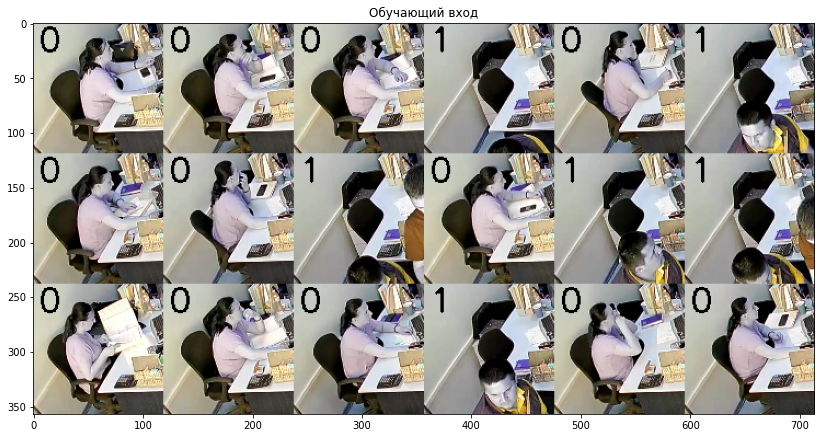

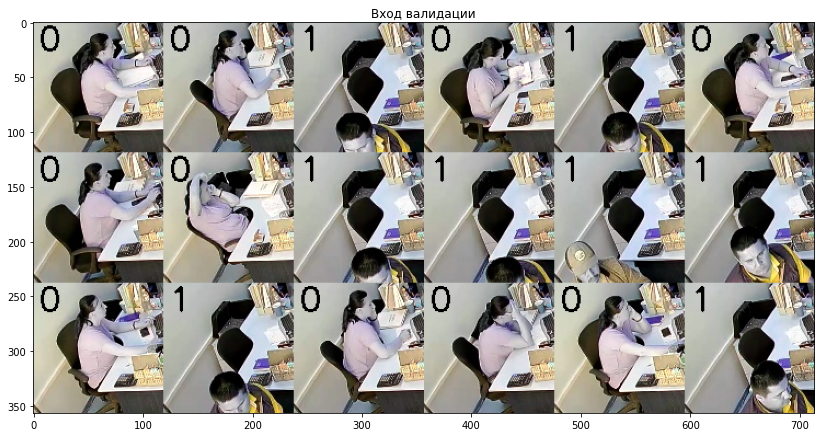

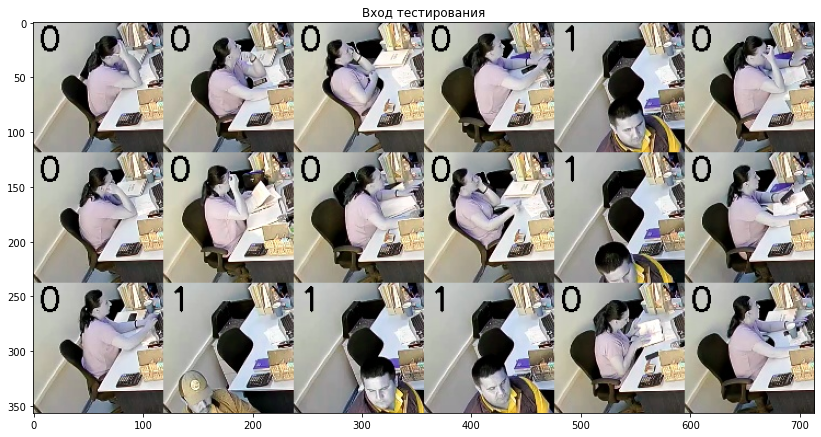

In [67]:
def check_data(X, y, title):
    n, m, cnt = 3, 6, -1
    to_plot = np.zeros((119 * n, 119 * m, 3), dtype=np.uint8)
    for i, j in product(range(n), range(m)):
        cnt += 1
        img = (X[cnt] * 255).astype(np.uint8).transpose(1, 2, 0).copy()
        img = cv2.putText(img, str(int(y[cnt])), (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2);
        to_plot[i * 119 : (i + 1) * 119, j * 119 : (j + 1) * 119, :] = img

    plt.figure(figsize=(14, 10))
    plt.imshow(to_plot)
    plt.title(title)
    plt.show()

check_data(X_train, y_train, "Обучающий вход")
check_data(X_valid, y_valid, "Вход валидации")
check_data(X_test, y_test, "Вход тестирования")

In [68]:
sampler_train = WeightedRandomSampler(y_train_weigths, num_samples=len(y_train_weigths))
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_dataloader = iter(DataLoader(train_dataset, batch_size=64, sampler=sampler_train))

sampler_valid = WeightedRandomSampler(y_valid_weigths, num_samples=len(y_valid_weigths))
valid_dataset = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))
valid_dataloader = iter(DataLoader(valid_dataset, sampler=sampler_valid))

sampler_test = WeightedRandomSampler(y_test_weigths, num_samples=len(y_test_weigths))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_dataloader = iter(DataLoader(test_dataset, sampler=sampler_test))

In [69]:
model = resnet34(pretrained=False)
model.fc = nn.Linear(512, 1, bias=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
print(device)

cpu


In [37]:
err_train, err_valid = [], []

In [38]:
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
criterion = nn.BCELoss()

epochs = 10
for epoch in range(epochs):
    temp_err_train, temp_err_valid = [], []
    for i in tqdm(range(len(train_dataloader))):
        optimizer.zero_grad()

    # Forward
        X, y = next(train_dataloader)
        X, y = X.to(device), y.to(device)
        y_pred = model.forward(X)

    # Calculate loss
        loss = criterion(y_pred, y)

    # Backward
        loss.backward()

    # Update weigths
        optimizer.step()

    # Validate
        X_valid, y_valid = next(valid_dataloader)
        X_valid, y_valid = X_valid.to(device), y_valid.to(device)
        valid_pred = model.forward(X_valid)
        valid_loss = criterion(valid_pred, y_valid)
    
    # Metrics
        temp_err_train.append(loss.item())
        temp_err_valid.append(valid_loss.item())
    
    # Metrics per epoch
    err_train.append(sum(temp_err_train) / len(temp_err_train))
    err_valid.append(sum(temp_err_valid) / len(temp_err_valid))
    torch.cuda.empty_cache()
    
    print(f'epoch: {epoch + 1}, train err: {err_train[-1]}, valid err: {err_valid[-1]}')

    




  0%|          | 0/136 [00:00<?, ?it/s]

RuntimeError: ignored